In [1]:
! pip install grad-cam
! pip install medmnist

In [78]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import torch
import numpy as np
import cv2
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, random_split
from torchvision import models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
from torchvision.transforms import ToPILImage
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device("cpu")
if torch.backends.mps.is_available(): # MPS for Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")

model = models.resnet50(pretrained=True)
num_input_channels = 1  # Grayscale images have only one channel
num_classes = 14
model.conv1 = nn.Conv2d(num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)

model.to(device)
target_layers = [model.layer4]

In [79]:
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
print(info)

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_subset_size = 7000
full_train_set = DataClass(split='train', transform=data_transform, download=True)
train_subset, _ = random_split(full_train_set, [train_subset_size, len(full_train_set) - train_subset_size])

val_subset_size = 1500
val_set = DataClass(split='val', transform=data_transform, download=True)
val_subset, _ = random_split(val_set, [val_subset_size, len(val_set) - val_subset_size])

test_subset_size = 1500
test_set = DataClass(split='test', transform=data_transform, download=True)
test_subset, _ = random_split(test_set, [test_subset_size, len(test_set) - test_subset_size])

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

{'python_class': 'ChestMNIST', 'description': 'The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/chestmnist.npz?download=1', 'MD5': '02c8a6516a18b556561a56cbdd36c4a8', 'task': 'multi-label, binary-class', 'label': {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}, 'n_channels': 1, 'n_samples': {'train': 78468, 'val': 11219, 'test': 22433}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: /home/viet/.medmnist/chestmnist.npz
Using downloaded

BREAKYY
14


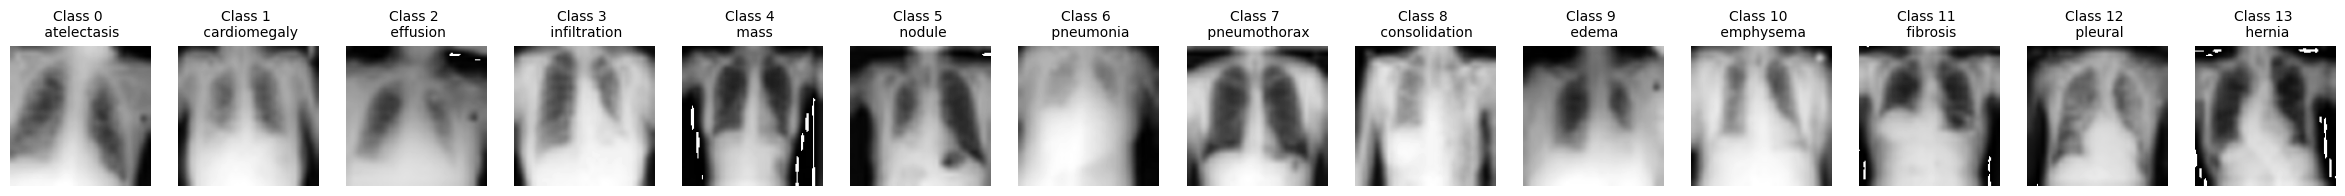

In [82]:
input_images_dict = {}

for image in test_loader.dataset:
    image_class = image[1]
    if 1 in image_class:
        image_class_index = np.where(image_class == 1)[0][0]

        if image_class_index not in input_images_dict:
            input_images_dict[image_class_index] = image[0]
            if len(input_images_dict) == 14:
                print("BREAKYY")
                break
print(len(input_images_dict))

resize_transform = transforms.Resize((128, 128), interpolation=Image.BICUBIC)
input_images_resized = {index: resize_transform(input_image) for index, input_image in input_images_dict.items()}

input_images_np = np.array([np.array(transforms.ToPILImage()(input_image)) for input_image in input_images_resized.values()])
input_images_np = np.float32(input_images_np) / 255


# Plot all images in one row
fig, axes = plt.subplots(1, 14, figsize=(30, 30))

for i, ax in enumerate(axes):
    ax.imshow(input_images_np[i, :, :], cmap="gray")
    ax.text(0.5, 1.15, f"Class {i} \n {info['label'][str(i)]}", ha='center', va='center', transform=ax.transAxes, fontsize=10)

    ax.axis('off')

plt.show()



# Showing the metrics on top of the CAM :
def custom_visualize_score(visualization, score, name, percentiles):
    font_size_name = 0.3
    font_size_description = 0.25
    font_size_percentiles = 0.3
    font_size_info = 0.3

    visualization = cv2.putText(visualization, name, (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX, font_size_name, (255,255,255), 1, cv2.LINE_AA)
    # visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
    #     cv2.FONT_HERSHEY_SIMPLEX, font_size_description, (255,255,255), 1, cv2.LINE_AA)
    # visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
    #     cv2.FONT_HERSHEY_SIMPLEX, font_size_percentiles, (255,255,255), 1, cv2.LINE_AA)
    # visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
    #     cv2.FONT_HERSHEY_SIMPLEX, font_size_info, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 40),
        cv2.FONT_HERSHEY_SIMPLEX, font_size_info, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def custom_benchmark(input_tensor, input_image, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [# ("GradCAM", GradCAM(model=model, target_layers=target_layers)),
        ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
        # ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
        # ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
        # ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))
    ]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        input_image_rgb = np.stack((input_image,) * 3, axis=-1)
        visualization = show_cam_on_image(input_image_rgb, attribution, use_rgb=True)
        visualization = custom_visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

Using device: cuda


Training-loop:   0%|          | 0/219 [00:00<?, ?it/s]

Validation-loop: 100%|██████████| 47/47 [00:05<00:00,  8.97it/s]


Grad-cam testing
Class 0 Accuracy: 0.00%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.60%
Class 3 Accuracy: 2.03%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


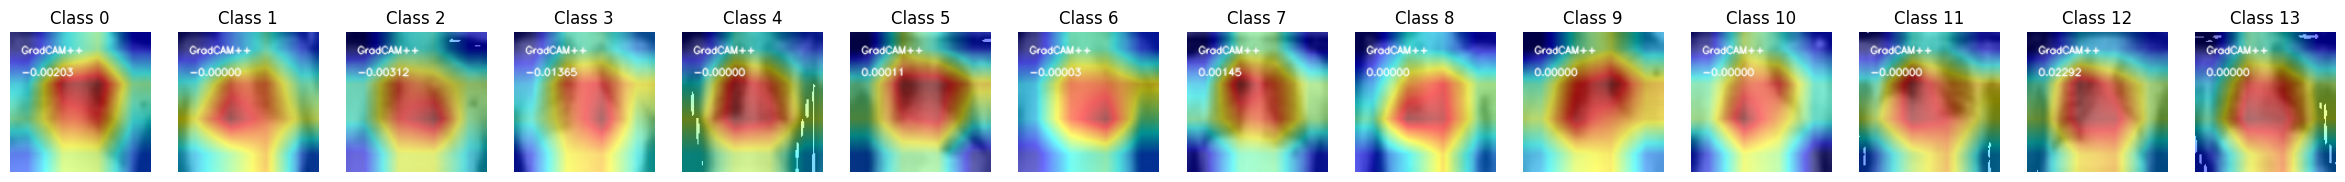

Train Epoch: 1 Loss: 0.183718 Validation loss: 0.185569 Acc: 94.860975 


Validation-loop: 100%|██████████| 47/47 [00:02<00:00, 16.94it/s]


Grad-cam testing
Class 0 Accuracy: 0.28%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.77%
Class 3 Accuracy: 2.15%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


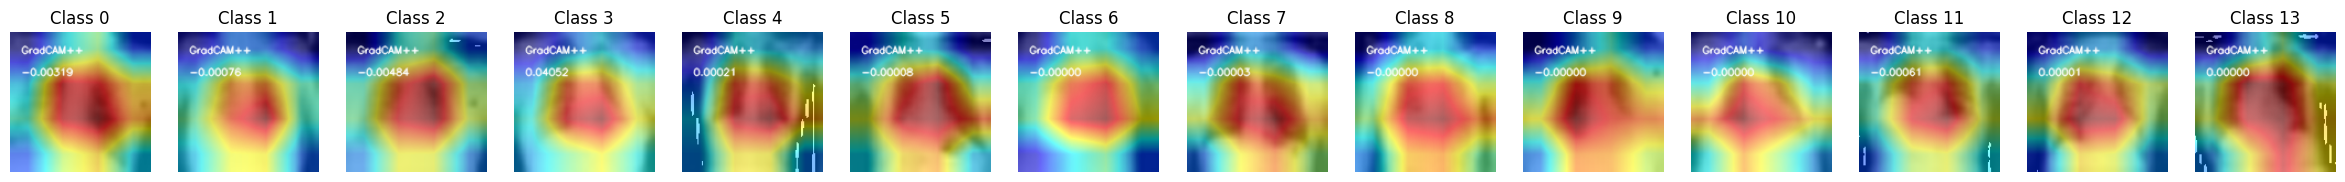

Train Epoch: 2 Loss: 0.188240 Validation loss: 0.182981 Acc: 94.804577 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.58it/s]


Grad-cam testing
Class 0 Accuracy: 0.19%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.52%
Class 3 Accuracy: 1.89%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


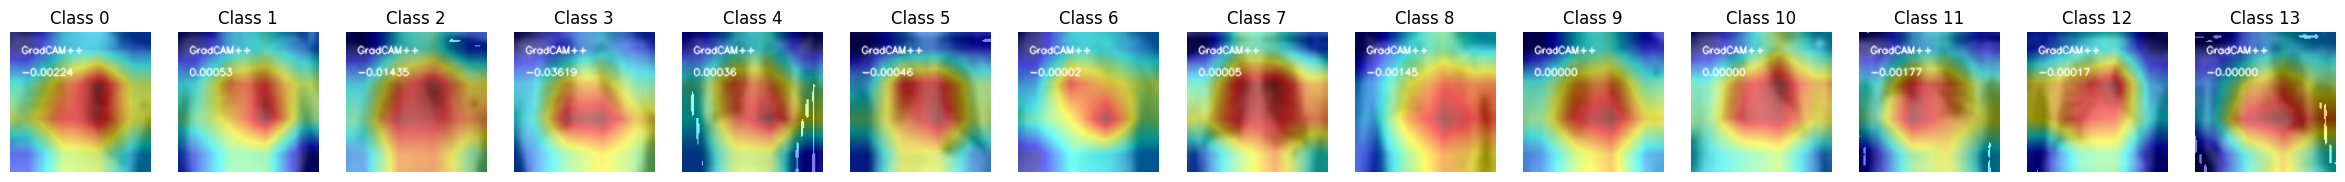

Train Epoch: 3 Loss: 0.181012 Validation loss: 0.178534 Acc: 94.906841 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 15.01it/s]


Grad-cam testing
Class 0 Accuracy: 0.14%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.42%
Class 3 Accuracy: 1.60%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


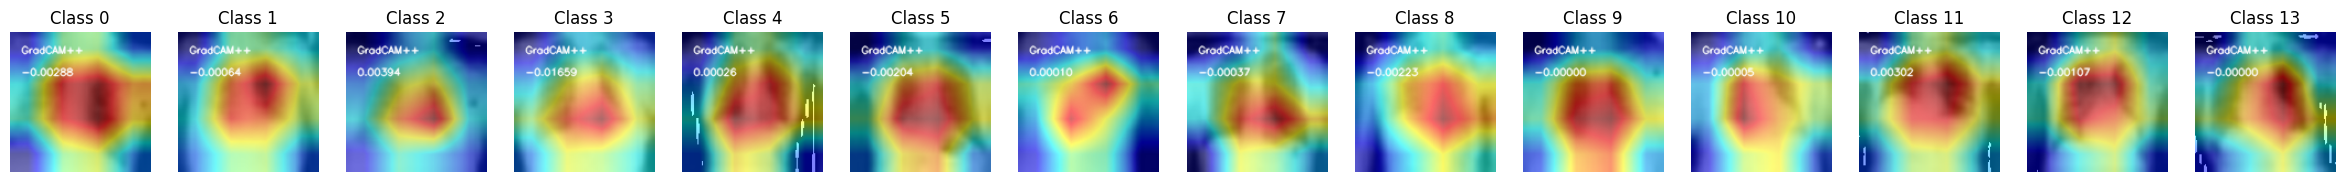

Train Epoch: 4 Loss: 0.178710 Validation loss: 0.180866 Acc: 94.896649 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.83it/s]


Grad-cam testing
Class 0 Accuracy: 0.11%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.48%
Class 3 Accuracy: 1.51%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


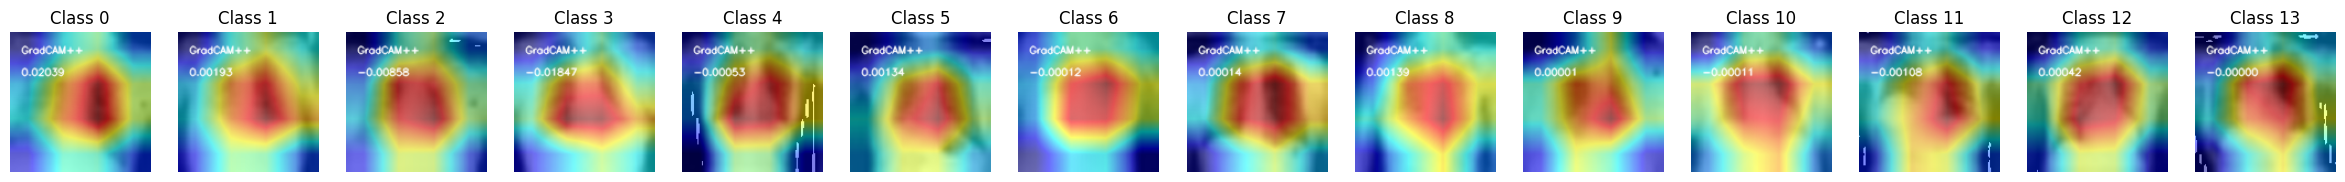

Train Epoch: 5 Loss: 0.176690 Validation loss: 0.181368 Acc: 94.900046 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.65it/s]


Grad-cam testing
Class 0 Accuracy: 0.09%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.48%
Class 3 Accuracy: 1.39%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


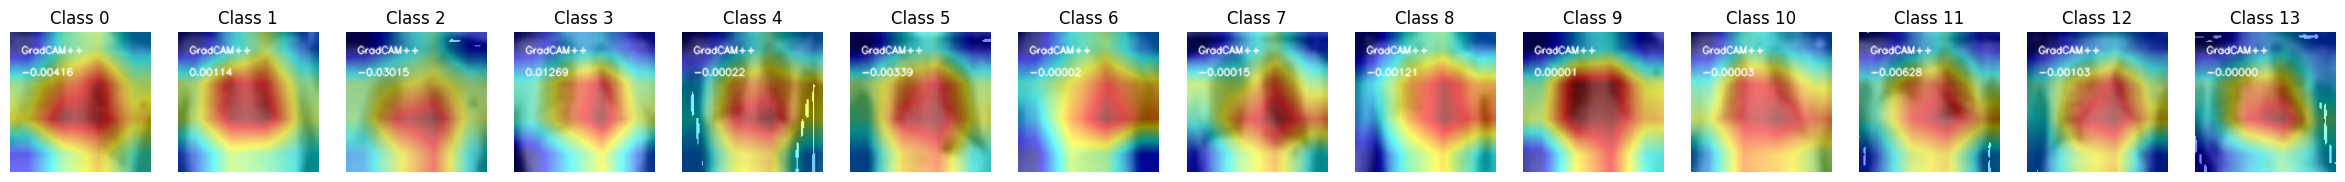

Train Epoch: 6 Loss: 0.175066 Validation loss: 0.178072 Acc: 94.916694 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.12it/s]


Grad-cam testing
Class 0 Accuracy: 0.08%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.53%
Class 3 Accuracy: 1.36%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


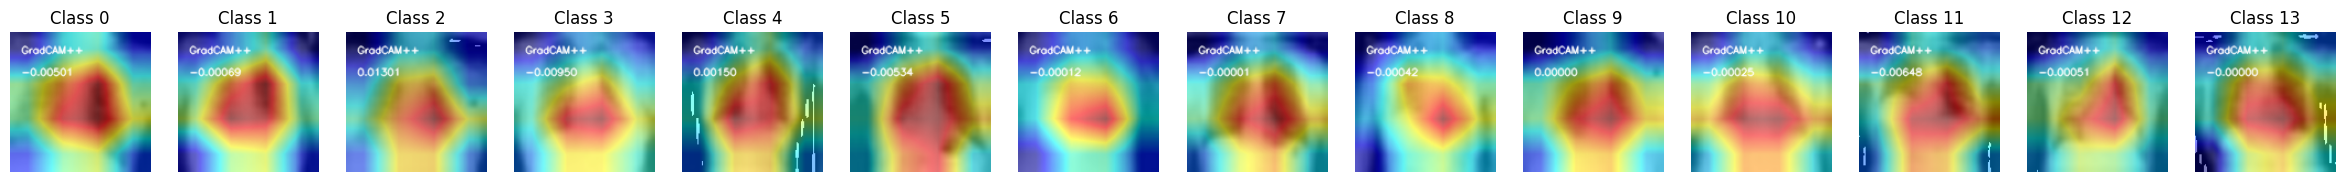

Train Epoch: 7 Loss: 0.173408 Validation loss: 0.178252 Acc: 94.886117 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.64it/s]


Grad-cam testing
Class 0 Accuracy: 0.07%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.61%
Class 3 Accuracy: 1.38%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


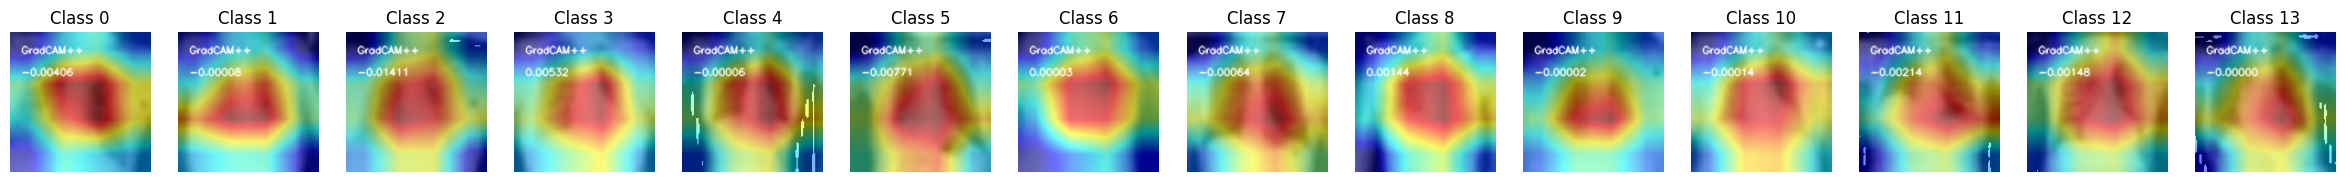

Train Epoch: 8 Loss: 0.172302 Validation loss: 0.176952 Acc: 94.899367 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.41it/s]


Grad-cam testing
Class 0 Accuracy: 0.06%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.68%
Class 3 Accuracy: 1.48%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


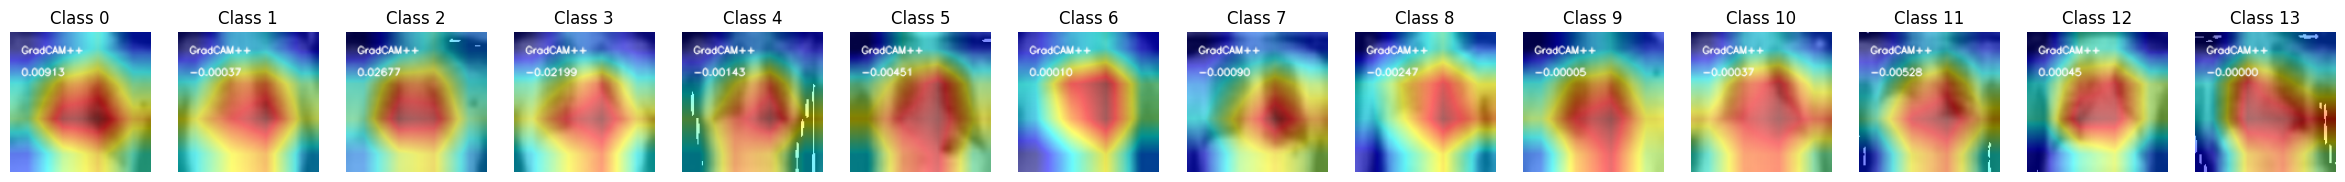

Train Epoch: 9 Loss: 0.171859 Validation loss: 0.176961 Acc: 94.907860 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.25it/s]


Grad-cam testing
Class 0 Accuracy: 0.07%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.81%
Class 3 Accuracy: 1.52%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


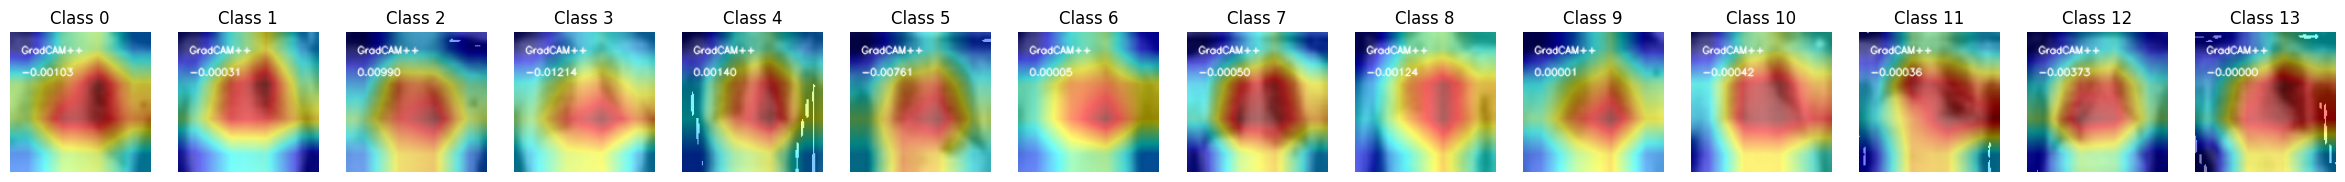

Train Epoch: 10 Loss: 0.170062 Validation loss: 0.176887 Acc: 94.910239 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Grad-cam testing
Class 0 Accuracy: 0.06%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 0.98%
Class 3 Accuracy: 1.63%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


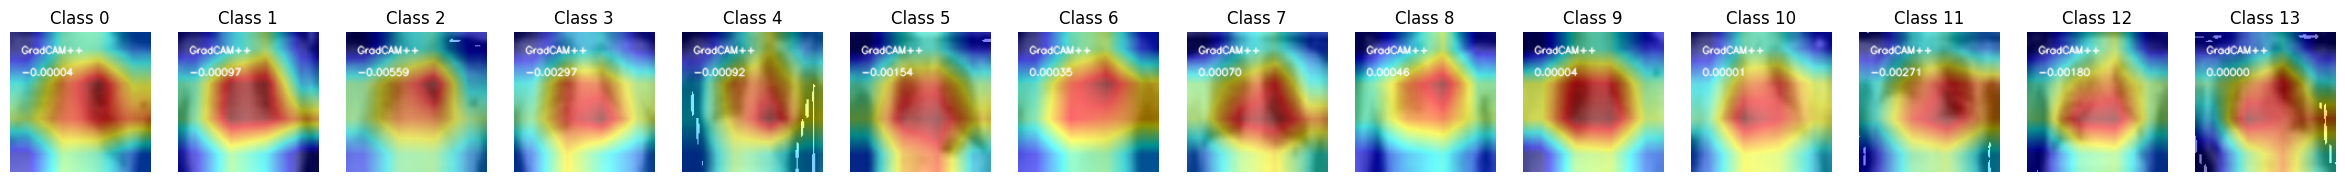

Train Epoch: 11 Loss: 0.169219 Validation loss: 0.177060 Acc: 94.912957 


Validation-loop: 100%|██████████| 47/47 [00:04<00:00, 11.55it/s]


Grad-cam testing
Class 0 Accuracy: 0.08%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 1.23%
Class 3 Accuracy: 1.77%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


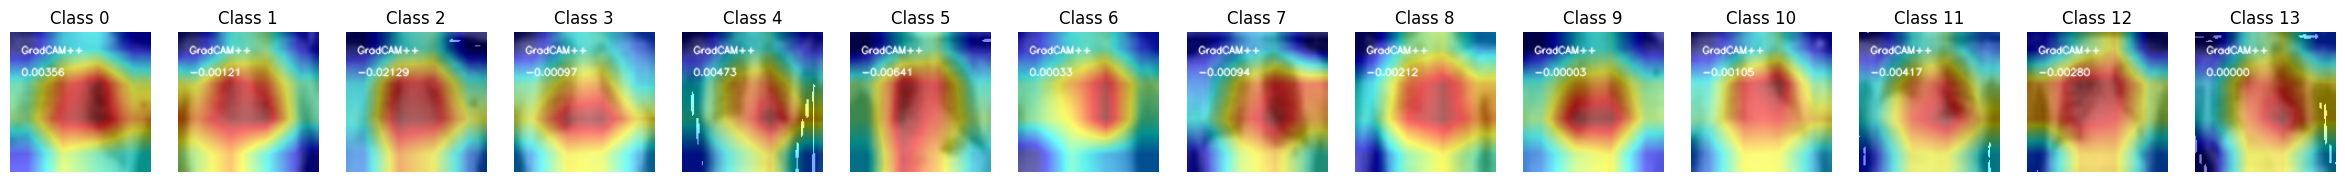

Train Epoch: 12 Loss: 0.167313 Validation loss: 0.176759 Acc: 94.913636 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Grad-cam testing
Class 0 Accuracy: 0.11%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 1.59%
Class 3 Accuracy: 1.83%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


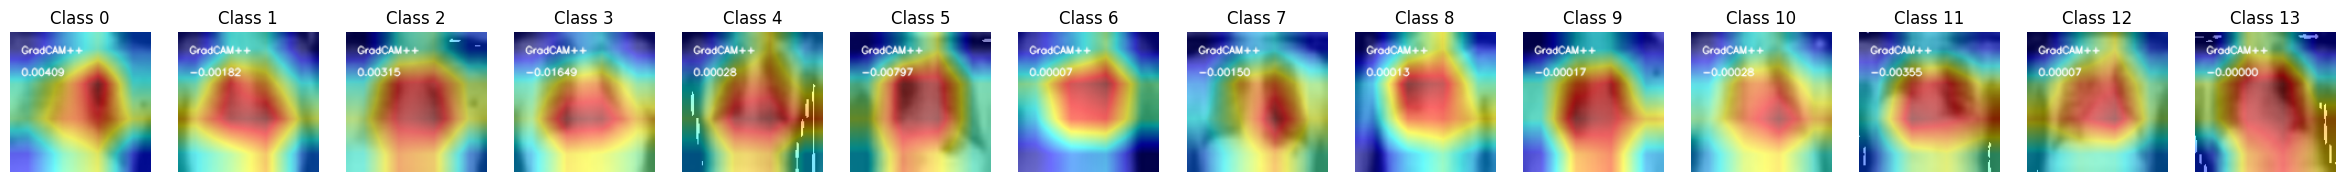

Train Epoch: 13 Loss: 0.166381 Validation loss: 0.177606 Acc: 94.901065 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.43it/s]


Grad-cam testing
Class 0 Accuracy: 0.13%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 2.08%
Class 3 Accuracy: 1.98%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


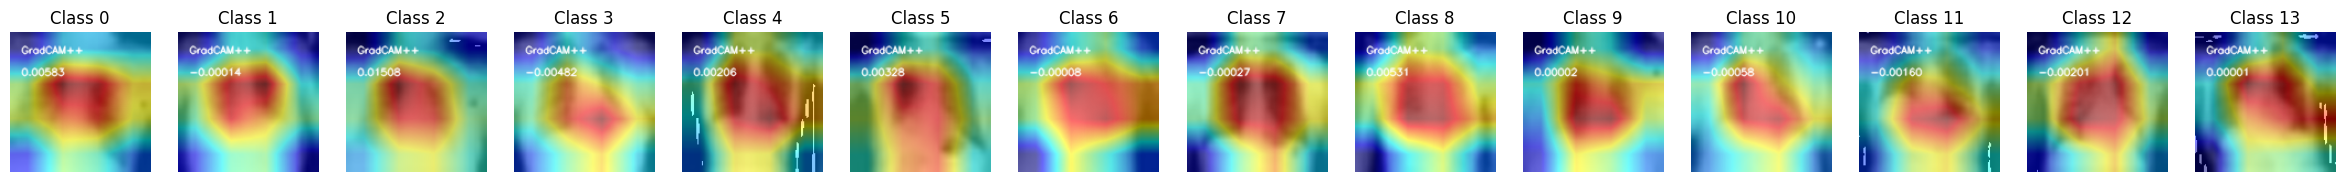

Train Epoch: 14 Loss: 0.164484 Validation loss: 0.177265 Acc: 94.909219 


Validation-loop: 100%|██████████| 47/47 [00:03<00:00, 13.61it/s]


Grad-cam testing
Class 0 Accuracy: 0.20%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 2.49%
Class 3 Accuracy: 2.13%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


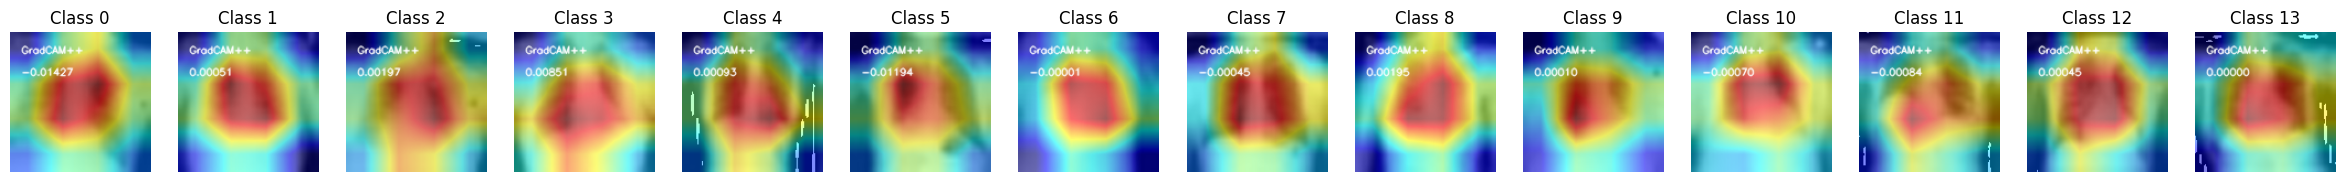

Train Epoch: 15 Loss: 0.163743 Validation loss: 0.178691 Acc: 94.906162 


Validation-loop: 100%|██████████| 47/47 [00:04<00:00, 10.56it/s]


Grad-cam testing
Class 0 Accuracy: 0.30%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 2.95%
Class 3 Accuracy: 2.19%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


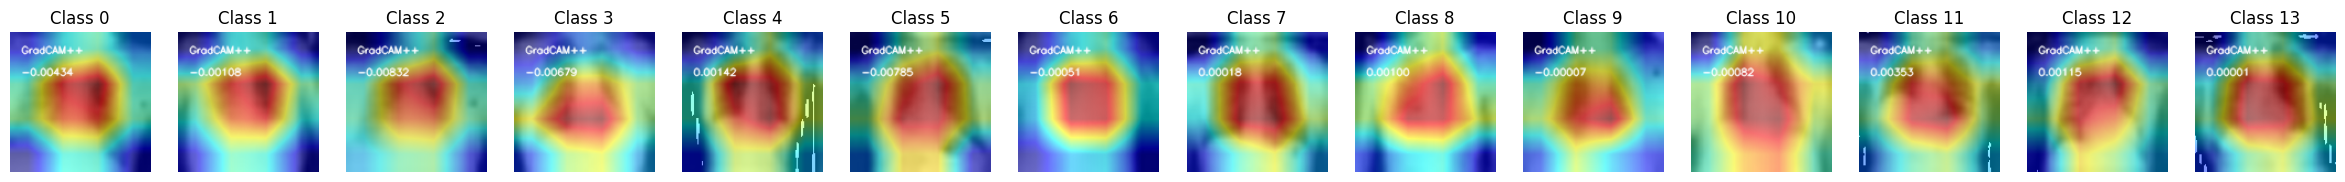

Train Epoch: 16 Loss: 0.162893 Validation loss: 0.178516 Acc: 94.930963 


Validation-loop: 100%|██████████| 47/47 [00:05<00:00,  9.37it/s]


Grad-cam testing
Class 0 Accuracy: 0.48%
Class 1 Accuracy: 0.00%
Class 2 Accuracy: 3.41%
Class 3 Accuracy: 2.39%
Class 4 Accuracy: 0.00%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 0.00%
Class 7 Accuracy: 0.00%
Class 8 Accuracy: 0.00%
Class 9 Accuracy: 0.00%
Class 10 Accuracy: 0.00%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 0.00%
Class 13 Accuracy: 0.00%


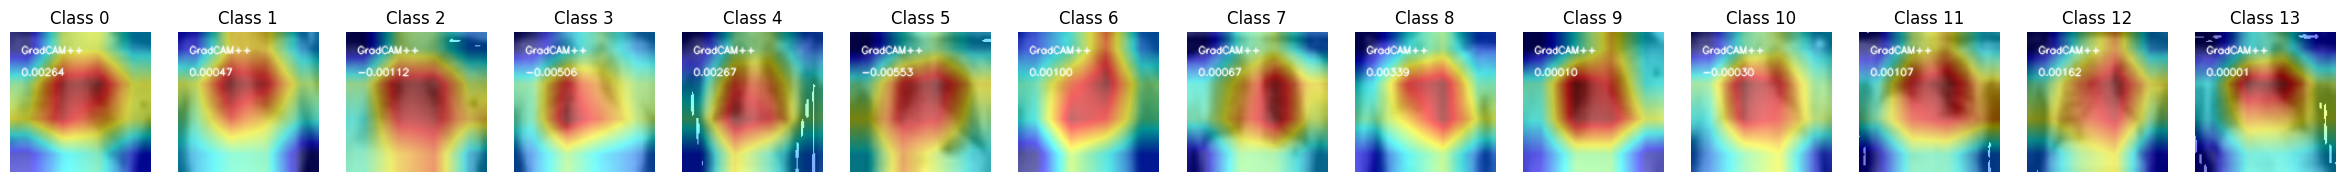

Train Epoch: 17 Loss: 0.160234 Validation loss: 0.182148 Acc: 94.903783 


Training-loop:  38%|███▊      | 84/219 [00:31<00:49,  2.70it/s]


KeyboardInterrupt: 

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from IPython.display import display

# You are expected to save the models during training
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###
saved_models = None
num_classes = 14

def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []

        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            loss = criterion(output, target.float())
            preds = torch.sigmoid(output).detach().cpu() > 0.5  # Assuming threshold of 0.5
            labels = target.detach().cpu()

            # Calculate accuracy for each class separately
            class_acc = np.mean(preds.numpy() == labels.numpy(), axis=0)
            acc = np.mean(class_acc)
            
            losses.append(loss.item())
            accuracies.append(acc)

            for c in range(num_classes):
                class_correct[c] += torch.sum((preds[:, c] == labels[:, c]) & (labels[:, c] == 1)).item()
                class_total[c] += torch.sum(labels[:, c] == 1).item()

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for _, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device).long()
                output = model(data)
                loss = criterion(output, target.float())
                pred = output.detach().cpu() > 0.5  # Assuming threshold of 0.5
                valid_losses.append(loss.item())

        # We suggest you modify this code to run the continuous explanations
        print(f"Grad-cam testing")
        target_layers = [model.layer4]
        
        class_accuracies = class_correct / class_total
        for c, acc in enumerate(class_accuracies):
            print(f"Class {c} Accuracy: {acc * 100:.2f}%")


        # # load input image from bloodmnist dataloader
        # input_image = train_loader.dataset[0][0].unsqueeze(0).to(device)
        # resize_transform = transforms.Resize((128, 128))
        # resized_input_image = resize_transform(input_image)

        result_images = []
        for i in range(num_classes):
            resized_input_image = input_images_resized[i].unsqueeze(0).to(device)
            input_image = input_images_np[i]
            result_image = custom_benchmark(resized_input_image, input_image, target_layers, category=i)
            result_images.append(result_image)
        # Display the result images in separate rows
        fig, axs = plt.subplots(1, num_classes, figsize=(30, 30 * num_classes))

        for class_idx in range(num_classes):
            axs[class_idx].imshow(result_images[class_idx])
            axs[class_idx].axis('off')
            axs[class_idx].set_title(f'Class {class_idx}')

        plt.show()
        # display(result_image)


        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )

    return model

print(f"Using device: {device}")
model = train(device, model, train_loader, epochs=60, learning_rate=0.0001)

# save model
saved_models = model
torch.save(saved_models, 'saved_models.pt')